# Hate Speech Detection

The data set we will use for the hate speech detection model consists of a test and train set. The training package includes a list of 31,962 tweets, a corresponding ID and a tag 0 or 1 for each tweet. The particular sentiment we need to detect in this dataset is whether or not the tweet is based on hate speech.

[Source link](https://thecleverprogrammer.com/2020/08/19/hate-speech-detection-model/)

## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

## Loading the dataset

In [2]:
df = pd.read_csv("data/tweets.csv")
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


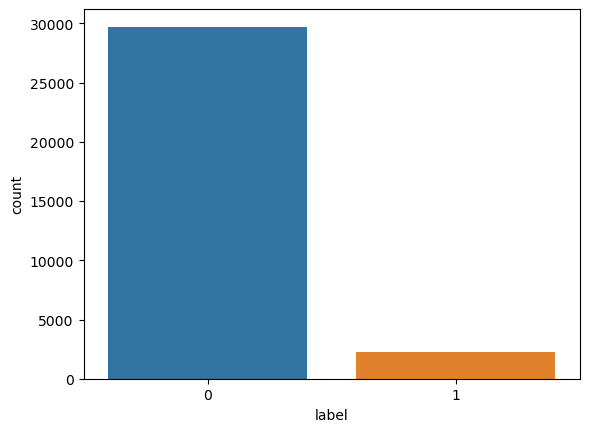

In [3]:
sns.countplot(df, x="label");

**Hint:** The dataset is very imbalanced.

## Cleaning the dataset

The regex pattern used in this line has multiple parts separated by the | character, representing different patterns to be substituted:
- `(@[A-Za-z0-9]+)`: This pattern matches Twitter usernames or handles, starting with the @ symbol, followed by alphanumeric characters.
- `([^0-9A-Za-z \t])`: This pattern matches any character that is not alphanumeric, whitespace, or a tab.
- `(\w+:\/\/\S+)`: This pattern matches URLs starting with http:// or https://, followed by any non-whitespace characters.
- `^rt`: This pattern matches the string "rt" at the beginning of a line, which is often used in retweets.
- `http.+?`: This pattern matches any string starting with "http" and followed by any character, using non-greedy matching.

### Cleaning function

In [4]:
import re

def clean_text(text: str) -> str:
    text = text.lower()
    pattern = r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"
    text = re.sub(pattern=pattern, repl=" ", string=text)
    text = re.sub(" +", " ", text)
    text = text.strip()
    return text

In [5]:
clean_df = df.copy()
clean_df["tweet"] = clean_df["tweet"].apply(clean_text)
clean_df.head()

,id,label,tweet
0,1,0,when a father is dysfunctional and is so selfi...
1,2,0,thanks for lyft credit i can t use cause they ...
2,3,0,bihday your majesty
3,4,0,model i love u take with u all the time in ur
4,5,0,factsguide society now motivation


Compare one example

In [6]:
df.iloc[3, 2]

'#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  '

In [7]:
clean_df.iloc[3, 2]

'model i love u take with u all the time in ur'

## Handling Imbalanced data

The tweets regarding hate speeches are comparatively lesser than others, so this is a situation of an unbalanced data.

There are a number of methods you can use to deal with this.

One approach is to use either oversampling or downsampling.

In the case of oversampling, we use a function that repeatedly samples, with replacement, from the minority class until the class is the same size as the majority.

In [8]:
from sklearn.utils import resample

majority_df = clean_df[clean_df["label"] == 0]
minority_df = clean_df[clean_df["label"] == 1]

minority_upsampled = resample(
    minority_df,
    replace=True,
    n_samples=len(majority_df),
    random_state=123,
)

upsampled_df = pd.concat([minority_upsampled, majority_df])
upsampled_df["label"].value_counts()

label
1    29720
0    29720
Name: count, dtype: int64

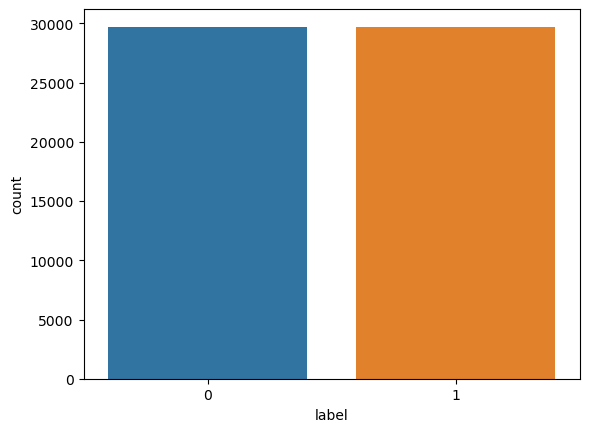

In [9]:
sns.countplot(upsampled_df, x="label");

## Matrix of features and labels

In [10]:
X = upsampled_df["tweet"].values
y = upsampled_df["label"].values

print(f"X {X.shape}")
print(f"y {y.shape}")

X (59440,)
y (59440,)


## Splitting the dataset to train and test

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

print(f"X_train {X_train.shape}")
print(f"X_test  {X_test.shape}")
print(f"y_train {y_train.shape}")
print(f"y_test  {y_test.shape}")

X_train (44580,)
X_test  (14860,)
y_train (44580,)
y_test  (14860,)


## Training the model with a pipeline

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier

pipeline_sgd = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("nb", SGDClassifier()),
])


model = pipeline_sgd.fit(X_train, y_train)

## Predicting the test set

In [13]:
y_pred = pipeline_sgd.predict(X_test)
result = pd.DataFrame({"Actual": y_test, "Predict" : y_pred})
result.head(10)

,Actual,Predict
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
5,1,1
6,0,0
7,0,0
8,1,1
9,0,0


## Evaluating the model


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      7490
           1       0.95      0.98      0.97      7370

    accuracy                           0.97     14860
   macro avg       0.97      0.97      0.97     14860
weighted avg       0.97      0.97      0.97     14860



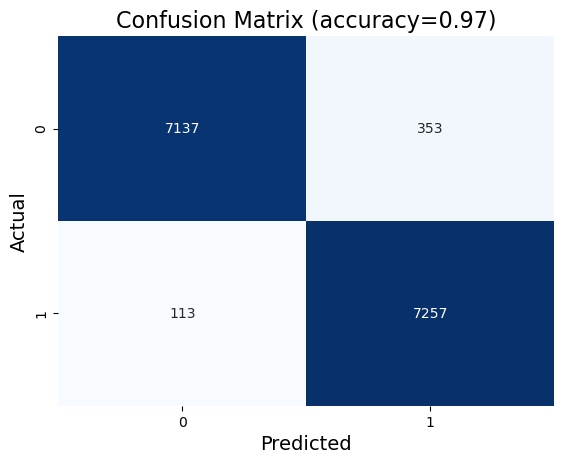

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nClassification Report:\n{report}")
ax = sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, fmt="d")
ax.set_xlabel("Predicted", fontsize=14)
ax.set_ylabel("Actual", fontsize=14)
ax.set_title(f"Confusion Matrix (accuracy={accuracy:.2f})", fontsize=16);

## Live prediction

In [15]:
def live_prediction(tweet):
    tweet = clean_text(tweet)
    X_example = np.array([tweet], dtype="object")
    prediction = pipeline_sgd.predict(X_example)
    print(f"Example tweet:\n{tweet!r}")
    if prediction[0] == 1:
        print("This tweet is an example of 'Hate Speech'")
    else:
        print("This tweet is an example of 'Not Hate Speech'")
    print("-" * 50)

In [16]:
hate_tweet_example = X_test[y_test == 1][100]
live_prediction(hate_tweet_example)

hate_tweet_example = X_test[y_test == 0][100]
live_prediction(hate_tweet_example)

Example tweet:
'are you black amp feel like the are stomping you listen retweet tampa miami'
This tweet is an example of 'Hate Speech'
--------------------------------------------------
Example tweet:
'vegetal new music studiotime djlife dj producer studio film single deephouse'
This tweet is an example of 'Not Hate Speech'
--------------------------------------------------
